# Results from WandB


## Imports

In [1]:
from community.utils.plotting import set_style
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
from itertools import product
import ipywidgets as widgets
import os

In [2]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh
from community.utils.plotting import legend_without_duplicate_labels
from community.data.datasets.mnist import estimate_covariance

In [3]:
%load_ext autoreload
%autoreload 2

## Load Results

In [5]:
def load_pd_file(sweep_id=None, run_id=None):
    assert not (
        sweep_id is None and run_id is None
    ), "Please provide either a sweep_id or a run_id"
    final_path = f"{sweep_id}/" if sweep_id else f"runs/{run_id}/"

    try:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{final_path}/metric_table"
        )
    except FileNotFoundError:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{final_path}/metric_table_safe"
        )

    p = total_data["sparsity"]
    total_data["q_metric"] = 0.5 * (1 - p) / (1 + p)

    try:
        total_data["n_conns"] = (
            (total_data["n_hidden"] ** 2 * total_data["sparsity"]).round().astype(int)
        )
        total_data["n_conns_sqrt"] = np.sqrt(total_data["n_conns"])
    except KeyError:
        pass

    return total_data

In [6]:
def single_filter(data, key, value):
    if key[0] == "!":
        if value is None:
            return ~data[key[1:]].isnull()
        else:
            return data[key[1:]] != value
    else:
        if value is None:
            return data[key].isnull()
        else:
            return data[key] == value


def filter_data(data, v_params):
    data = data.copy()
    for key, value in v_params.items():
        if key in data.columns or (key[0] == "!" and key[1:] in data.columns):
            if isinstance(value, list):
                filter = np.sum(
                    [single_filter(data, key, v) for v in value], axis=0
                ).astype(bool)
            else:
                filter = single_filter(data, key, value)

        data = data[filter]

    return data, filter


def get_values(data, x="n_hidden", y="sparsity", value="retraining_global_diff"):
    return data[[x, y, value]].values.T


def get_all_v_params(varying_params, excluded_params={}):
    return [
        {
            k: p
            for k, p in zip(varying_params.keys(), params)
            if k not in excluded_params
        }
        for params in product(*varying_params.values())
    ]

In [159]:
# run_id = "nrfi6oxg"
run_id = None

sweep_id = "hqx9dkom"  # metric (fig 1)
sweep_id = "h4213kcu"  # heatmaps (fig 2)

total_data = load_pd_file(run_id=run_id, sweep_id=sweep_id)


In [160]:
total_data["n_classes"] = total_data["data_type"].apply(
    lambda d: {"double_digits": 10, "double_letters": 16}[d]
)

try:
    covariances = {}
    for n in total_data["n_classes"].unique():
        for c in total_data["cov_ratio"].unique():
            covariances[n, c] = estimate_covariance(c, int(n))
    total_data["covariance"] = [
        covariances[n, c] for c, n in total_data[["cov_ratio", "n_classes"]].values
    ]
    total_data["covariance"] = total_data["covariance"].abs()
    total_data["covariance"].min()
except KeyError:
    pass

In [161]:
# Normalize metric values

total_data_base = filter_data(total_data, {"!metric_name": "base_correlations"})[0]

# filter_params = [{'metric_name' : 'retraining', 'ag' : i} for i in range(2)]
# f_datas = [filter_data(total_data, fp) for fp in filter_params]
total_data_base["base_metric_value"] = total_data_base["metric_value"].copy()

total_data_base.loc[
    filter_data(total_data_base, {"metric_name": "correlations"})[1],
    "base_metric_value",
] = filter_data(total_data, {"metric_name": "base_correlations"})[0][
    "metric_value"
].array

total_data_base.loc[
    filter_data(total_data_base, {"!metric_name": "correlations"})[1],
    "base_metric_value",
] = 0.1

total_data_base["normed_metric_value"] = (
    np.clip(
        total_data_base["metric_value"] - total_data_base["base_metric_value"], 0, 1
    )
) / (1 - total_data_base["base_metric_value"])

In [162]:

# Target specific data
target_datas = [
    filter_data(total_data_base, {"!ag": "all", "target": i})[0] for i in range(2)
]

if True : 
        
    # Compute ablations ratios
    for data in target_datas:
        data.loc[filter_data(data, {"metric_name": "ablations"})[1], "metric_value"] = (
            1
            - filter_data(data, {"metric_name": "ablations"})[0]["metric_value"].array
            / filter_data(total_data_base, {"metric_name": "retraining", "ag": "all"})[0][
                "metric_value"
            ].array
        )
    

In [163]:
# Create agent specific data
ag_data = target_datas[0].copy()
[
    ag_data.pop(k)
    for k in ["target", "metric_value", "normed_metric_value", "base_metric_value"]
]
ag_data["metric_value"] = (
    target_datas[0]["normed_metric_value"].array
    - target_datas[1]["normed_metric_value"].array
) / (
    target_datas[0]["normed_metric_value"].array
    + target_datas[1]["normed_metric_value"].array
)
ag_datas = [filter_data(ag_data, {"ag": i})[0] for i in range(2)]

# Create model specific data
model_data = ag_datas[0].copy()
[model_data.pop(k) for k in ["ag", "metric_value"]]
model_data["metric_value"] = (
    np.abs(ag_datas[0]["metric_value"].array - ag_datas[1]["metric_value"].array) / 2
)

for c in model_data.columns:
    model_data.loc[model_data[c].isnull(), c] = "None"

In [166]:
metric_names = ["retraining", "ablations", "correlations"]
metrics_values = {m : filter_data(model_data, {"metric_name": m})[0]["metric_value"] for m in metric_names}


In [9]:
raise StopIteration

StopIteration: 

## Fig 1

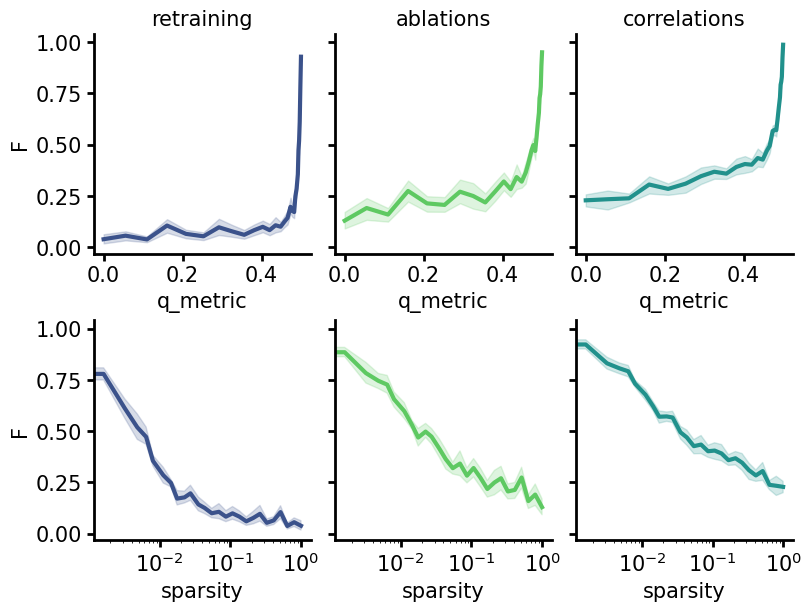

In [117]:
set_style()
palette = sns.palettes.color_palette("viridis", len(metric_names))
colors = [palette[i] for i in [0, 2, 1]]
fig, axs = plt.subplots(2, 3, figsize=(8, 6), sharey=True, constrained_layout=True)

for i, (x_axs, x) in enumerate(zip(axs, ["sparsity", "q_metric"][::-1])):
    for ax, metric_name, c in zip(x_axs, metric_names, colors):
        filter_params = {
            "metric_name": metric_name,
            "step": 1,
            "noise_ratio": "None",
            "n_bot": "None",
        }
        f_data = filter_data(model_data, filter_params)[0]
        sns.lineplot(
            data=f_data, x=x, y="metric_value", color=c, ax=ax
        )  # , style="noise_ratio", hue='n_bot')
        ax.set_ylabel("F")
        ax.set_xlabel(x)
        if x == "sparsity":
            ax.set_xscale("log")
        if i == 0:
            ax.set_title(metric_name)

In [143]:
metrics = np.stack([filter_data(model_data, {"metric_name": m})[0]["metric_value"] for m in metric_names]).astype(float)

In [145]:
metrics

array([[0.92302749, 0.92538811, 0.93150843, ..., 0.07131845, 0.9095629 ,
        0.20501694],
       [0.95857022, 0.94998321, 0.97361935, ..., 0.17999408, 0.97759674,
        0.3829117 ],
       [0.99870761, 0.99537097, 0.9917142 , ..., 0.16266268, 0.99372774,
        0.27699836]])

In [144]:
np.corrcoef(metrics)

array([[1.        , 0.97224316, 0.97220932],
       [0.97224316, 1.        , 0.97729396],
       [0.97220932, 0.97729396, 1.        ]])

In [ ]:
# fig.savefig('../../results/imgs/norm_metrics.svg', dpi=300)

## Fig 2

In [168]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh

In [169]:
def get_values(data, x="n_hidden", y="sparsity", value="retraining"):
    return data[[x, y, value]].values.T

In [60]:
heatmap_data = filter_data(
    model_data,
    {
        "step": 1,
        "common_input": False,
        "common_readout": False,
        "n_bot": 5,
        # "task": "parity-digits-both",
        # "covariance": varying_params["covariance"],
        "data_type": ["double_digits", "double_letters"][0],
        # "metric_name": "ablations",
    },
)[0]
heatmap_data = heatmap_data[heatmap_data["sparsity"] > 0]
heatmap_data.shape

(212090, 23)

Plotting Heatmaps:   0%|          | 0/36 [00:00<?, ?it/s]

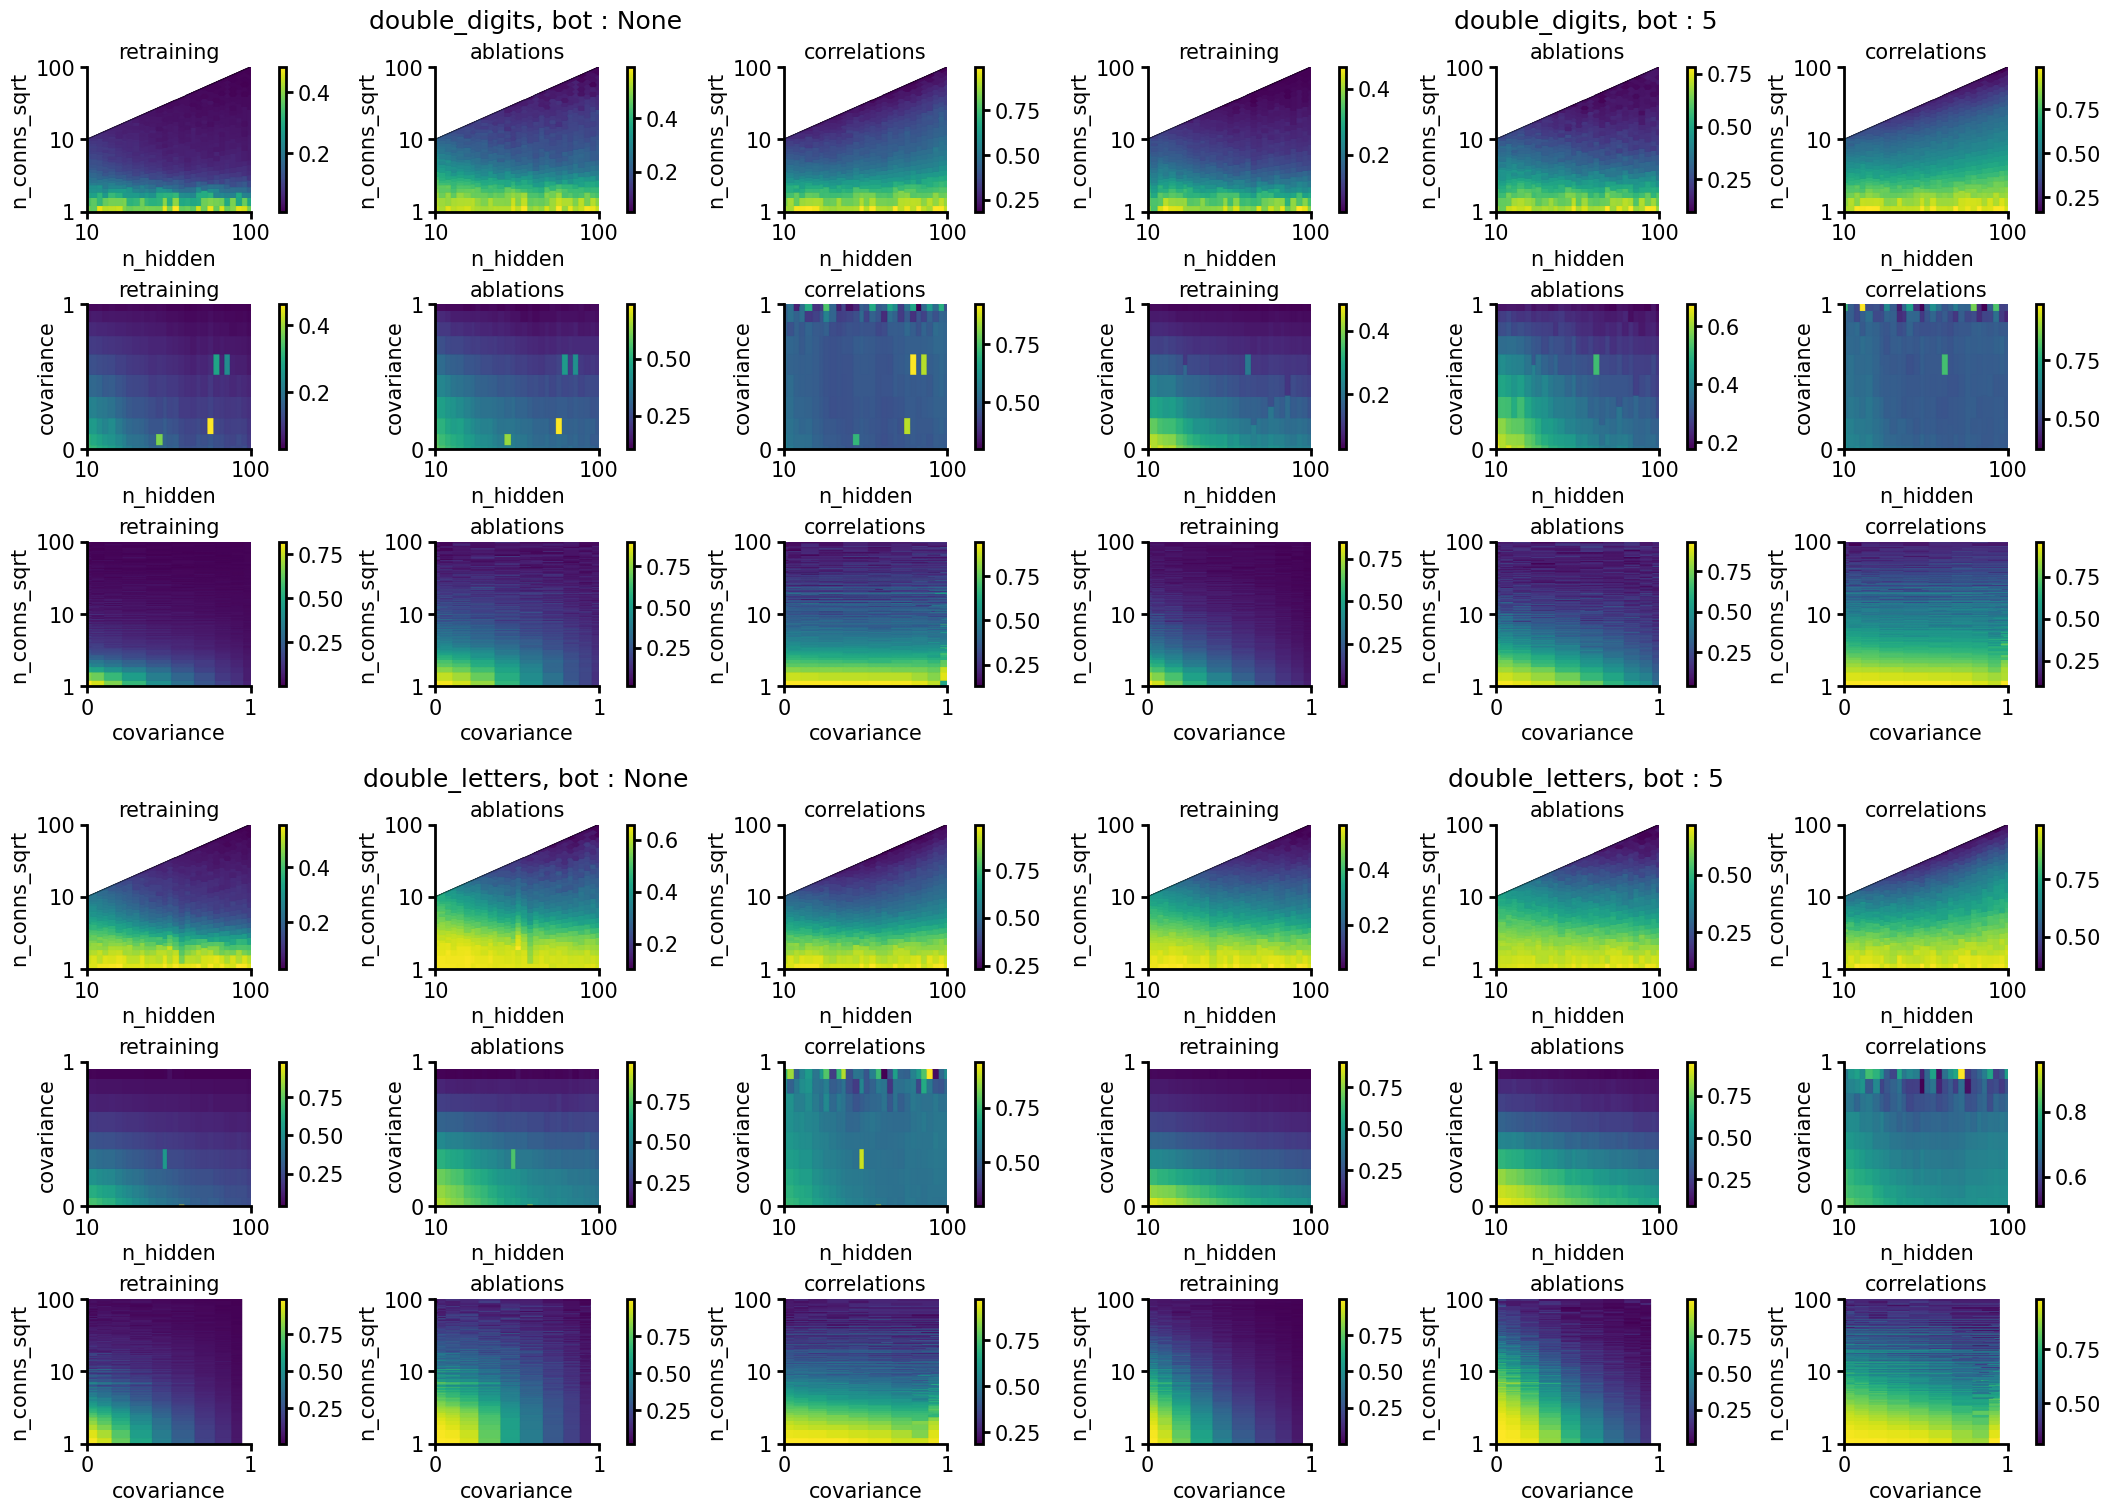

In [195]:
set_style()

metric = "metric_value"

x_label = "n_hidden"
y_label = "n_conns_sqrt"

metric_names = ["retraining", "ablations", "correlations"]
n_bots = ["None", 5]
datas = ["double_digits", "double_letters"]

x_labels = ["n_hidden", "n_hidden", "covariance"]
y_labels = ["n_conns_sqrt", "covariance", "n_conns_sqrt"]
log_scales = {"n_hidden": True, "n_conns_sqrt": True, "covariance": False}

ticks = {
    "n_hidden": [10, 100],
    "n_conns_sqrt": [1, 10, 100],
    "covariance": [total_data["covariance"].min(), total_data["covariance"].max()],
}
ticks_labels = {
    "n_hidden": [10, 100],
    "n_conns_sqrt": [1, 10, 100],
    "covariance": [0, 1],
}

pbar = tqdm(
    total=len(datas) * len(n_bots) * len(metric_names) * len(x_labels),
    desc="Plotting Heatmaps: ",
)

fig = plt.figure(
    figsize=(3.5 * len(metric_names) * len(n_bots), 2.5 * len(x_labels) * len(datas)),
    constrained_layout=True,
)
subfigs = fig.subfigures(len(datas), len(n_bots))

for (data_type, n_bot), subfig in zip(product(datas[:], n_bots), subfigs.flatten()):
    subfig.suptitle(f"{data_type}, bot : {n_bot}")
    axs = subfig.subplots(len(x_labels), len(metric_names))
    # fig, axs = plt.subplots(2, 3, figsize=(5*3, 5*2), constrained_layout=True)

    for (x_label, y_label), axs_b in zip(zip(x_labels, y_labels), axs):
        for metric_name, ax in zip(metric_names[:], axs_b):
            ax.set_title(metric_name)
            heatmap_data = filter_data(
                model_data,
                {
                    "step": 1,
                    "common_input": False,
                    "common_readout": False,
                    "n_bot": n_bot,
                    "data_type": data_type,
                    "metric_name": metric_name,
                    "!metric_value" : 'None',
                },
            )[0]
            heatmap_data = heatmap_data[heatmap_data["sparsity"] > 0]

            values = get_values(
                heatmap_data.groupby([x_label, y_label], as_index=False)[
                    [x_label, y_label, metric]
                ].mean(),
                x_label,
                y_label,
                metric,
            )

            (
                (X, Y),
                (X_mesh, Y_mesh),
                Z,
                (fig, ax),
                cbar,
            ) = compute_and_plot_colormesh(
                values,
                (fig, ax),
                log_scale=[log_scales[x_label], log_scales[y_label]],
                resolution=300,
                method="nearest",
                exclude_sup=(x_label == "n_hidden" and y_label == "n_conns_sqrt"),
                minmax=None,
                imshow=False,
                # random=True
            )
            pbar.update(1)

            # ax.xaxis.set_tick_params(labelbottom=False)
            # ax.yaxis.set_tick_params(labelleft=False)
            ax.minorticks_off()

            ax.set_xticks(ticks[x_label])
            ax.set_yticks(ticks[y_label])
            ax.set_xticklabels(ticks_labels[x_label])
            ax.set_yticklabels(ticks_labels[y_label])

            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)

    # raise StopIteration

# ax.set_ylim(1e-1, 1e2)

In [193]:
np.unique([str(type(u)) for u in heatmap_data[metric].unique()])

array(["<class 'float'>", "<class 'str'>"], dtype='<U15')

In [194]:
filter_data(heatmap_data, {"metric_value": 'None'})[0]

,step,best_acc,metric_name,sparsity,comms_start,data_type,n_bot,common_input,common_readout,nb_steps,...,run_id,done,seed,name,q_metric,n_conns,n_conns_sqrt,n_classes,covariance,metric_value
16,1,0.90439,ablations,0.8316,1,double_digits,5,False,False,2,...,0wutnddq,False,623,0wutnddq,0.045971,163,12.767145,10,0.905999,None
16,1,0.930194,ablations,0.2478,1,double_digits,5,False,False,2,...,1w2c8c4m,False,789,1w2c8c4m,0.30141,805,28.372522,10,0.905999,None
32,1,0.849672,ablations,0.0956,1,double_digits,5,False,False,2,...,3ubvmwj1,False,703,3ubvmwj1,0.412742,86,9.273618,10,0.65569,None
16,1,0.9273,ablations,0.0625,1,double_digits,5,False,False,2,...,4sjh9b4o,False,692,4sjh9b4o,0.441176,49,7.0,10,0.905999,None
32,1,0.833921,ablations,0.7521,1,double_digits,5,False,False,2,...,5g5vsx2z,False,795,5g5vsx2z,0.070744,2891,53.76802,10,0.00027,None
32,1,0.562891,ablations,0.0013,1,double_digits,5,False,False,2,...,6qtp0jbi,False,772,6qtp0jbi,0.498702,5,2.236068,10,0.052896,None
16,1,0.929312,ablations,0.0381,1,double_digits,5,False,False,2,...,brbopyji,False,732,brbopyji,0.463298,55,7.416198,10,0.905999,None
16,1,0.935612,ablations,0.0172,1,double_digits,5,False,False,2,...,e4xa579b,False,801,e4xa579b,0.483091,77,8.774964,10,0.905999,None
32,1,0.814062,ablations,0.0013,1,double_digits,5,False,False,2,...,f4sikp1t,False,748,f4sikp1t,0.498702,3,1.732051,10,0.767074,None
16,1,0.926474,ablations,1.0,1,double_digits,5,False,False,2,...,haibdgb6,False,653,haibdgb6,0.0,324,18.0,10,0.905999,None


((array([0.0065443 , 0.01111248, 0.01568065, 0.02024882, 0.02481699,
         0.02938517, 0.03395334, 0.03852151, 0.04308968, 0.04765785,
         0.05222603, 0.0567942 , 0.06136237, 0.06593054, 0.07049872,
         0.07506689, 0.07963506, 0.08420323, 0.0887714 , 0.09333958,
         0.09790775, 0.10247592, 0.10704409, 0.11161227, 0.11618044,
         0.12074861, 0.12531678, 0.12988495, 0.13445313, 0.1390213 ,
         0.14358947, 0.14815764, 0.15272582, 0.15729399, 0.16186216,
         0.16643033, 0.1709985 , 0.17556668, 0.18013485, 0.18470302,
         0.18927119, 0.19383937, 0.19840754, 0.20297571, 0.20754388,
         0.21211205, 0.21668023, 0.2212484 , 0.22581657, 0.23038474,
         0.23495292, 0.23952109, 0.24408926, 0.24865743, 0.2532256 ,
         0.25779378, 0.26236195, 0.26693012, 0.27149829, 0.27606647,
         0.28063464, 0.28520281, 0.28977098, 0.29433915, 0.29890733,
         0.3034755 , 0.30804367, 0.31261184, 0.31718002, 0.32174819,
         0.32631636, 0.33088453, 0

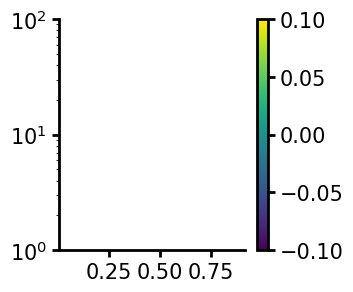

In [70]:
compute_and_plot_colormesh(
                values,
                None,
                log_scale=[log_scales[x_label], log_scales[y_label]],
                resolution=200,
                method="nearest",
                exclude_sup=True,
                minmax=None,
                imshow=False,
                # random=True
            )